# Reading in Polars and Data

In [4]:
import polars as pl
pl.Config.with_columns_kwargs = True

In [6]:
batting = pl.read_csv('Data/lahman baseball data/Batting.csv')
pitching = pl.read_csv('Data/lahman baseball data/Pitching.csv')
fielding = pl.read_csv('Data/lahman baseball data/Fielding.csv')
awards = pl.read_csv('Data/lahman baseball data/AwardsPlayers.csv')
salaries = pl.read_csv('Data/lahman baseball data/Salaries.csv')

# Gold Glove Data Set

In [9]:
'case is player, year, pos, league'

'case is player, year, pos, league'

In [11]:
fielding_awards = (fielding
.filter((pl.col('yearID') >= 2013))
.join(
     awards.rename({"notes": "POS"}) 
           .select(['playerID', 'yearID', 'awardID', 'lgID', 'POS'])  
           .filter((pl.col('awardID') == 'Gold Glove') & (pl.col('yearID') >= 2013)),
      on=['playerID', 'yearID', 'lgID'],
      how='left'
     )
.group_by(['playerID','yearID', 'lgID', 'POS', 'awardID'])
.agg(
     pl.col('InnOuts').sum().alias('InnOuts'),
     pl.col('PO').sum().alias('PO'),
     pl.col('A').sum().alias('A'),
     pl.col('E').sum().alias('E'),
     pl.col('DP').sum().alias('DP'),
     pl.col('PB').cast(int).sum().alias('PB'),
     pl.col('WP').cast(int).sum().alias('WP'),
     pl.col('SB').cast(int).sum().alias('SB'),
     pl.col('CS').cast(int).sum().alias('CS'),
     pl.col('ZR').cast(int).sum().alias('ZR') 
    )    
.with_columns(
        pl.when(pl.col('awardID').is_null())
          .then(pl.lit('No'))
          .otherwise(pl.lit('Yes'))
          .alias('Gold Glove?'),
         pl.when(pl.col('yearID') == 2023)
          .then(pl.lit('Validation'))
          .otherwise(pl.lit('Training'))
          .alias('Training-Validation')
              )
.drop(pl.col('awardID'))
                  )
# fielding_awards = fielding_awards.filter(pl.col('Gold Glove?') == 'Yes', pl.col('POS') == 'C', pl.col('yearID') == 2017)
fielding_awards.write_csv('data/fielding_awards.csv')

fielding_awards

playerID,yearID,lgID,POS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,Gold Glove?,Training-Validation
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""buttrty01""",2018,"""AL""","""P""",49,2,3,0,0,0,0,0,0,0,"""No""","""Training"""
"""holtbr01""",2021,"""AL""","""3B""",1549,43,134,4,10,0,0,0,0,0,"""No""","""Training"""
"""leitema02""",2023,"""NL""","""P""",193,5,3,0,0,0,0,0,0,0,"""No""","""Validation"""
"""blackch02""",2017,"""NL""","""OF""",4099,339,4,4,3,0,0,0,0,0,"""No""","""Training"""
"""chatwty01""",2016,"""NL""","""P""",474,13,22,2,2,0,0,0,0,0,"""No""","""Training"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""webbry01""",2013,"""NL""","""P""",241,3,19,0,1,0,0,0,0,0,"""No""","""Training"""
"""gonsast01""",2018,"""AL""","""P""",74,2,3,0,0,0,0,0,0,0,"""No""","""Training"""
"""hugheph01""",2018,"""NL""","""P""",62,0,0,0,0,0,0,0,0,0,"""No""","""Training"""


# Salary Dataset

In [14]:
'case is player year' 'salary, batting, fielding, pitching'

'case is player yearsalary, batting, fielding, pitching'

In [16]:
salaries_final = (salaries
.filter(pl.col('yearID') >= 2006)
.join(fielding
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'lgID', 'teamID'],
        how='left'
     )
.join(batting
        .rename({"CS": "CS_batting", "SB": "SB_Batting"})
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'teamID', 'stint', 'lgID', 'G'],
        how='left',
     )
.join(pitching
        .rename({
            "GIDP": "GIDP_pitching", "H": "H_pitching", "HR": "HR_pitching", "BB": "BB_pitching",
            "SO": "SO_pitching", "IBB": "IBB_pitching", "WP": "WP_pitching", "HBP": "HBP_pitching",
            "SH": "SH_pitching", "SF": "SF_pitching", "R": "R_pitching", "GIDP": "GIDP_pitching"
                })
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'teamID', 'stint', 'lgID', 'G', 'GS'],
        how='left'
     )
.group_by(['playerID','yearID'])
.agg(
     pl.col('salary').sum().alias('salary'),
     pl.col('InnOuts').sum().alias('InnOuts'),
     pl.col('PO').sum().alias('PO'),
     pl.col('A').sum().alias('A'),
     pl.col('E').sum().alias('E'),
     pl.col('DP').sum().alias('DP'),
     pl.col('PB').cast(int).sum().alias('PB'),
     pl.col('WP').cast(int).sum().alias('WP'),
     pl.col('SB').cast(int).sum().alias('SB'),
     pl.col('CS').cast(int).sum().alias('CS'),
     pl.col('ZR').cast(int).sum().alias('ZR'),
     pl.col('G').sum().alias('G'),
     pl.col('AB').sum().alias('AB'),
     pl.col('R').sum().alias('R'),
     pl.col('H').sum().alias('H'),
     pl.col('2B').sum().alias('2B'),
     pl.col('3B').sum().alias('3B'),
     pl.col('HR').sum().alias('HR'),
     pl.col('SB_Batting').sum().alias('SB_batting'),
     pl.col('CS_batting').sum().alias('CS_batting'),
     pl.col('BB').sum().alias('BB_batting'),
     pl.col('SO').sum().alias('SO_batting'),
     pl.col('IBB').sum().alias('IBB_batting'),
     pl.col('HBP').sum().alias('HBP_batting'),
     pl.col('SH').sum().alias('Sacrifice Hits'),
     pl.col('SF').sum().alias('Sacrifice Flies'),
     pl.col('GIDP').sum().alias('GIDP'),
     pl.col('GS').sum().alias('GS'),
     pl.col('CG').sum().alias('CG'),
     pl.col('SHO').sum().alias('SHO'),
     pl.col('SV').sum().alias('SV'),
     pl.col('IPouts').sum().alias('IPOuts'),
     pl.col('H_pitching').sum().alias('H_pitching'),
     pl.col('ER').sum().alias('ER_pitching'),
     pl.col('HR_pitching').sum().alias('HR_pitching'),
     pl.col('BB_pitching').sum().alias('BB_pitching'),
     pl.col('SO_pitching').sum().alias('SO_pitching'),
     pl.col('BAOpp').sum().alias('BAOpp'),
     pl.col('ERA').sum().alias('ERA_pitching'),
     pl.col('IBB_pitching').sum().alias('IBB_pitching'),
     pl.col('WP_pitching').sum().alias('WP_pitching'),
     pl.col('HBP_pitching').sum().alias('HBP_pitching'),
     pl.col('BK').sum().alias('Balk'),
     pl.col('BFP').sum().alias('Batters Faced by Pitcher'),
     pl.col('GF').sum().alias('Games Finished'),
     pl.col('SH').sum().alias('SH_pitching'),
     pl.col('SF').sum().alias('SF_pitching'),
     pl.col('GIDP_pitching').sum().alias('GIDP_pitching')
    )   
.with_columns(
         pl.when(pl.col('yearID') == 2016)
          .then(pl.lit('Validation'))
          .otherwise(pl.lit('Training'))
          .alias('Training-Validation')
               )
)
salaries_final.write_csv('data/salaries_final.csv')
salaries_final

playerID,yearID,salary,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,G,AB,R,H,2B,3B,HR,SB_batting,CS_batting,BB_batting,SO_batting,IBB_batting,HBP_batting,Sacrifice Hits,Sacrifice Flies,GIDP,GS,CG,SHO,SV,IPOuts,H_pitching,ER_pitching,HR_pitching,BB_pitching,SO_pitching,BAOpp,ERA_pitching,IBB_pitching,WP_pitching,HBP_pitching,Balk,Batters Faced by Pitcher,Games Finished,SH_pitching,SF_pitching,GIDP_pitching,Training-Validation
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""ingebr01""",2011,5500000,2192,76,163,9,12,0,0,0,0,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""
"""saarlki01""",2006,354000,364,9,27,0,1,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,2,364,149,64,19,53,52,0.308,4.75,3,3,3,0,548,7,0,0,17,"""Training"""
"""mechegi01""",2007,7400000,648,15,22,3,5,0,0,0,0,0,34,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,34,1,0,0,648,218,88,22,62,156,0.263,3.67,2,3,3,0,906,0,0,0,20,"""Training"""
"""longoev01""",2010,950000,3992,127,276,14,46,0,0,0,0,0,151,574,96,169,46,5,22,15,5,72,124,12,5,0,10,15,151,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,10,0,"""Training"""
"""brantmi02""",2014,1500000,3913,271,12,1,2,0,0,0,0,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,146,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""mileywa01""",2013,500500,608,14,24,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,608,201,80,21,66,147,0.261,3.55,4,13,4,0,847,0,0,0,23,"""Training"""
"""colonba01""",2016,7250000,575,12,40,3,5,0,0,0,0,0,34,60,4,5,2,0,1,0,0,1,40,0,0,4,0,3,33,0,0,0,575,200,73,24,32,128,0.268,3.43,2,0,3,0,791,0,4,0,19,"""Validation"""
"""ramirha01""",2006,327000,3970,258,411,26,111,0,0,0,0,0,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,153,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""


# Classification Problem

## Setting Up

In [61]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [63]:
from sklearn.metrics import confusion_matrix

def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
            'balanced_accuracy' :  0.5*tn / (tn+fp) + 0.5*tp / (tp+fn),
            'specificity'       :  tn / (tn+fp),
            'sensitivity'       :  tp / (tp+fn),
             'ppv'              :  tp / (tp + fp),
             'npv'              :  tn / (tn + fn)}


In [65]:
fielding_awards

playerID,yearID,lgID,POS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,Gold Glove?,Training-Validation
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""buttrty01""",2018,"""AL""","""P""",49,2,3,0,0,0,0,0,0,0,"""No""","""Training"""
"""holtbr01""",2021,"""AL""","""3B""",1549,43,134,4,10,0,0,0,0,0,"""No""","""Training"""
"""leitema02""",2023,"""NL""","""P""",193,5,3,0,0,0,0,0,0,0,"""No""","""Validation"""
"""blackch02""",2017,"""NL""","""OF""",4099,339,4,4,3,0,0,0,0,0,"""No""","""Training"""
"""chatwty01""",2016,"""NL""","""P""",474,13,22,2,2,0,0,0,0,0,"""No""","""Training"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""webbry01""",2013,"""NL""","""P""",241,3,19,0,1,0,0,0,0,0,"""No""","""Training"""
"""gonsast01""",2018,"""AL""","""P""",74,2,3,0,0,0,0,0,0,0,"""No""","""Training"""
"""hugheph01""",2018,"""NL""","""P""",62,0,0,0,0,0,0,0,0,0,"""No""","""Training"""


In [67]:
fielding_awards.columns

['playerID',
 'yearID',
 'lgID',
 'POS',
 'InnOuts',
 'PO',
 'A',
 'E',
 'DP',
 'PB',
 'WP',
 'SB',
 'CS',
 'ZR',
 'Gold Glove?',
 'Training-Validation']

## Preparing Data

In [137]:
fielding_training = fielding_awards.filter(pl.col('Training-Validation') == 'Training').drop(['Gold Glove?', 'playerID', 'yearID', 'lgID', 'POS', 'Training-Validation'])
gold_glove_train = fielding_awards.filter(pl.col('Training-Validation') == 'Training').drop(['playerID', 'yearID', 'lgID', 'POS', 'Training-Validation']).select('Gold Glove?')

fielding_validation = fielding_awards.filter(pl.col('Training-Validation') == 'Validation').drop(['Gold Glove?', 'playerID', 'yearID', 'lgID', 'POS', 'Training-Validation'])
gold_glove_validation = fielding_awards.filter(pl.col('Training-Validation') == 'Validation').drop(['playerID', 'yearID', 'lgID', 'POS', 'Training-Validation']).select('Gold Glove?')

fielding_stats_train = fielding_training.to_pandas()
gold_glove_train = gold_glove_train.to_pandas()

fielding_stats_validation = fielding_validation.to_pandas()
gold_glove_validation = gold_glove_validation.to_pandas()

## Grid Search

### Tree Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid = {'max_depth': [None, 1,2,3,4,5],
              'min_samples_split' : [1, 5, 10],
               'min_samples_leaf' : [1, 5, 10],
              'class_weight':[None, "balanced"]
              }


In [ ]:
from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3, cv=cv_obj)

grid_search.fit(fielding_training, gold_glove_train)

In [76]:
grid_search.best_score_

0.9881267356293654

In [78]:
grid_search.best_params_

{'class_weight': None,
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [80]:
best_model_tree = grid_search.best_estimator_
best_model_tree

DecisionTreeClassifier(max_depth=1, min_samples_split=5)

### Random Forest Grid Search

In [82]:
rf_param_grid = {'n_estimators': 10 ** np.arange(1, 3),
              'max_depth': [None, 1,2,3,4,5],
              'min_samples_split' : [1, 5, 10],
               'min_samples_leaf' : [1, 5, 10],
              'class_weight':[None, "balanced"]
              }

rf_param_grid

{'n_estimators': array([ 10, 100], dtype=int32),
 'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10],
 'class_weight': [None, 'balanced']}

In [ ]:
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, verbose=3, cv=cv_obj)

rf_grid_search.fit(fielding_training, gold_glove_train)

In [85]:
rf_grid_search.best_score_

0.9882822566246997

In [86]:
rf_grid_search.best_params_

{'class_weight': None,
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 10}

In [108]:
best_model_rf = rf_grid_search.best_estimator_
best_model_rf

RandomForestClassifier(min_samples_leaf=5, min_samples_split=10,
                       n_estimators=10)

### Comparing Scores

In [94]:
rf_grid_search.best_score_ > grid_search.best_score_

True

In [100]:
gold_glove_validation_pred_rf = rf_grid_search.predict(fielding_validation)

In [102]:
get_metrics(gold_glove_validation, gold_glove_validation_pred_rf)

C:\Users\ben8h\AppData\Local\Temp\ipykernel_5440\987674393.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': 0.9864668922184631,
 'balanced_accuracy': 0.5,
 'specificity': 1.0,
 'sensitivity': 0.0,
 'ppv': nan,
 'npv': 0.9864668922184631}

## Fitting the Best Model

In [110]:
forest = RandomForestClassifier(min_samples_leaf=5, min_samples_split=10, n_estimators=10)
forest.fit(fielding_training, gold_glove_train)

C:\Users\ben8h\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_leaf=5, min_samples_split=10,
                       n_estimators=10)

## ROC Curve

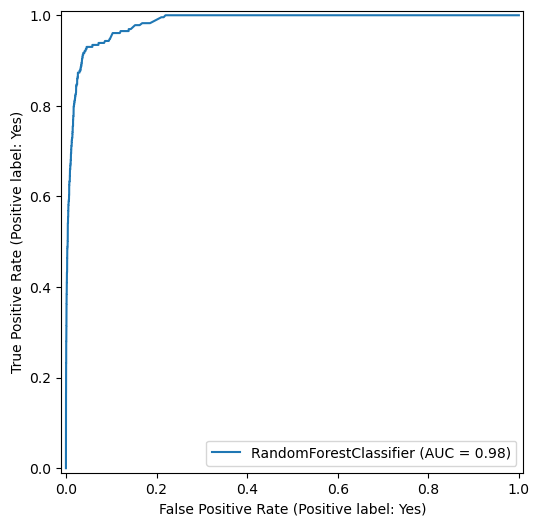

In [114]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = (8,6)

RocCurveDisplay.from_estimator(forest, fielding_training, gold_glove_train)

plt.show()

## AUC

In [116]:
def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf:  A fitted model object
        X:    The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)

In [118]:
y_test_probs = get_class_prob_df(forest, fielding_validation)

y_test_probs

,No,Yes
0,1.000000,0.000000
1,0.999765,0.000235
2,0.979644,0.020356
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
2064,1.000000,0.000000
2065,0.998363,0.001637
2066,0.971429,0.028571
2067,0.999765,0.000235


In [124]:
from sklearn.metrics import roc_auc_score

roc_auc_score(gold_glove_validation, y_test_probs['Yes'])

0.7747165255127039

## Balanced Success

In [142]:
# A balanced tree with some (arbitrary) limits
forest = RandomForestClassifier(min_samples_leaf=5, min_samples_split=10, n_estimators=10)
forest.fit(fielding_training, gold_glove_train)

y_test_pred = forest.predict(fielding_validation)
y_test_prob = get_class_prob_df(forest, fielding_validation)

C:\Users\ben8h\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [144]:
# The default tree
forest2 = RandomForestClassifier()
forest2.fit(fielding_training, gold_glove_train)

y_test_pred2 = forest.predict(fielding_validation)
y_test_prob2 = get_class_prob_df(forest2, fielding_validation)

C:\Users\ben8h\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [148]:
get_metrics(gold_glove_validation, y_test_pred)

C:\Users\ben8h\AppData\Local\Temp\ipykernel_5440\987674393.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': 0.9864668922184631,
 'balanced_accuracy': 0.5,
 'specificity': 1.0,
 'sensitivity': 0.0,
 'ppv': nan,
 'npv': 0.9864668922184631}

In [150]:
get_metrics(gold_glove_validation, y_test_pred2)

C:\Users\ben8h\AppData\Local\Temp\ipykernel_5440\987674393.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': 0.9864668922184631,
 'balanced_accuracy': 0.5,
 'specificity': 1.0,
 'sensitivity': 0.0,
 'ppv': nan,
 'npv': 0.9864668922184631}

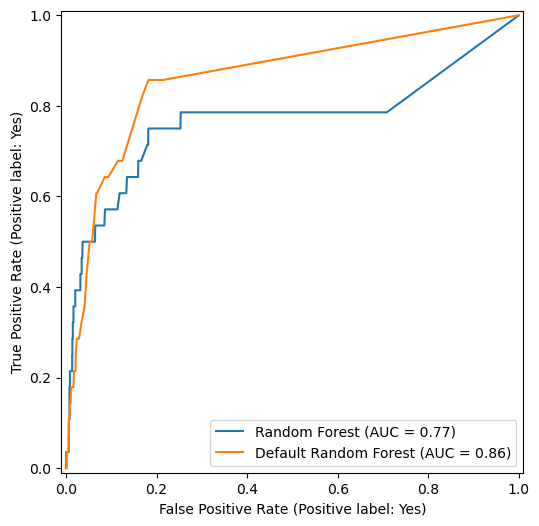

In [152]:
# Make a blank plot/axis
ax = plt.gca()

# Plot each ROC curve by passing in the axis object to ax = ...
RocCurveDisplay.from_estimator(forest, fielding_validation, gold_glove_validation, ax = ax, name = "Random Forest")
RocCurveDisplay.from_estimator(forest2, fielding_validation, gold_glove_validation, ax = ax, name = "Default Random Forest")

plt.show()

In [156]:
roc_auc_score(gold_glove_validation, y_test_probs['Yes'])

0.7747165255127039

In [154]:
roc_auc_score(gold_glove_validation, y_test_prob2['Yes'])

0.8604325610695037

# Regression Problem

In [ ]:
salaries.columns

In [ ]:
salaries_training = salaries_final.filter(pl.col('Training-Validation') == 'Training').drop('playerID','yearID','salary', 'Training-Validation')
salary_train = salaries_final.filter(pl.col('Training-Validation') == 'Training').drop('playerID','yearID','Training-Validation').select('salary')

salaries_validation = salaries_final.filter(pl.col('Training-Validation') == 'Validation').drop('playerID','yearID','salary', 'Training-Validation')
salary_validation = salaries_final.filter(pl.col('Training-Validation') == 'Validation').drop('playerID','yearID','Training-Validation').select('salary')

salaries_training = salaries_training.to_pandas()
salary_train = salary_train.to_pandas()

salaries_validation = salaries_validation.to_pandas()
salary_validation = salary_validation.to_pandas()


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#tree grid search

In [ ]:
tree_param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search = GridSearchCV(DecisionTreeRegressor(), tree_param_grid, verbose=3, cv=cv_obj)

grid_search.fit(salaries_training, salary_train)

In [ ]:
#forest grid search

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search = GridSearchCV(RandomForestRegressor(), rf_param_grid, verbose=3, cv=cv_obj)

grid_search.fit(salaries_training, salary_train)